In [59]:

import matplotlib.pyplot as plt
import numpy as np
import tensorflow
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, SimpleRNN, Flatten
from tensorflow.keras.preprocessing import sequence
import tensorflow.keras.callbacks as CallB
from tensorflow.keras.utils import plot_model
from collections import defaultdict

input dim = len of vocab = 29
output dim = size of embedding vector = 10
input len = len of your seq = len of word?

In [60]:
import pandas as pd
df = pd.read_csv('data.txt', sep=" ",header=None)
odf = df


df[0] = df[0].astype(str).apply(lambda x:" ".join(list(x)))
df[1] = df[1].astype(str).apply(lambda x:" ".join(list(x)))

print(df)

                                0                                    1
0         a p p r e h e n s i v e        a p p r e h e n s i v e w a y
1           d e s p e r a t e l y            e s p e r a t e l y d a y
2                         g r e w                          e w g r a y
3               n i g g a r d l y                i g g a r d l y n a y
4                   b r o u g h t                    o u g h t b r a y
...                           ...                                  ...
6506        c o m p u n c t i o n            o m p u n c t i o n c a y
6507          i n c i t e m e n t            i n c i t e m e n t w a y
6508            i m m e d i a t e              i m m e d i a t e w a y
6509  s o u t h - w e s t e r l y  o u t h s a y - e s t e r l y w a y
6510        c o n n e c t i o n s            o n n e c t i o n s c a y

[6511 rows x 2 columns]


In [61]:
df.columns = {"Encoder Input", "Output"}
df["Decoder Input"] = df["Output"].apply(lambda x: "<start> "+x[:-1])
df.head()

,Output,Encoder Input,Decoder Input
0,a p p r e h e n s i v e,a p p r e h e n s i v e w a y,<start> a p p r e h e n s i v
1,d e s p e r a t e l y,e s p e r a t e l y d a y,<start> d e s p e r a t e l
2,g r e w,e w g r a y,<start> g r e
3,n i g g a r d l y,i g g a r d l y n a y,<start> n i g g a r d l
4,b r o u g h t,o u g h t b r a y,<start> b r o u g h


In [62]:
train, test = train_test_split(df, test_size=0.2)

In [63]:
vocab_list = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z','\'','-','*','<start>']
# '1','2','3','4','5','6','7','8','9','0',
vocab = defaultdict(lambda : 0)
count = 1

for i in vocab_list:
    if vocab[i]==0:
        vocab[i] = count
        count += 1

In [74]:
X_train_encoder = [[vocab[char] for char in x.split() if vocab[char] != 0] for x in train["Encoder Input"].values]
X_train_decoder = [[vocab[char] for char in x.split() if vocab[char] != 0] for x in train["Decoder Input"].values]
Y_train = [[vocab[char] for char in x.split() if vocab[char] != 0] for x in train["Output"].values]
# print(Y_train)
X_test_encoder = [[vocab[char] for char in x.split() if vocab[char] != 0] for x in test["Encoder Input"].values]
X_test_decoder = [[vocab[char] for char in x.split() if vocab[char] != 0] for x in test["Decoder Input"].values]
Y_test = [[vocab[char] for char in x.split() if vocab[char] != 0] for x in test["Output"].values]


In [119]:
X_train_encoder = sequence.pad_sequences(X_train_encoder, maxlen=80)
X_train_decoder = sequence.pad_sequences(X_train_decoder, maxlen=80)
Y_train = sequence.pad_sequences(Y_train, maxlen=80)
# print(Y_train)
X_test_encoder = sequence.pad_sequences(X_test_encoder, maxlen=80)
X_test_decoder = sequence.pad_sequences(X_test_decoder, maxlen=80)
Y_test = sequence.pad_sequences(Y_test, maxlen=80)
print(X_train_encoder.shape)

(5208, 80)


In [121]:

def Encoder(vocab_size=31,embedding_size=10,input_length=80):
    encoder_inputs = Input(shape=(input_length,))
    embedder = Embedding(vocab_size, embedding_size, input_length=input_length)
    encoder_emb = embedder(encoder_inputs)
    encoder = SimpleRNN(embedding_size, return_state=True, name = "enc")
    encoder_outputs, encoder_last_state = encoder(encoder_emb)
    return encoder_inputs, encoder_outputs, encoder_last_state

def Decoder(encoder_last_state, vocab_size=31, embedding_size=10, input_length=80):
    decoder_inputs = Input(shape=(input_length,))
    embedder = Embedding(vocab_size, embedding_size, input_length=input_length)  
    decoder_emb = embedder(decoder_inputs)  
    decoder_rnn = SimpleRNN(embedding_size, return_sequences=True, return_state=True, name = "dec")
    decoder_outputs, _ = decoder_rnn(decoder_emb, initial_state=encoder_last_state)
    decoder_dense = Dense(vocab_size, activation="softmax")
    decoder_outputs = decoder_dense(decoder_outputs)
    return decoder_inputs, decoder_outputs

<class 'numpy.ndarray'>
Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_39 (InputLayer)           [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_40 (InputLayer)           [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_38 (Embedding)        (None, 50, 10)       310         input_39[0][0]                   
__________________________________________________________________________________________________
embedding_39 (Embedding)        (None, 50, 10)       310         input_40[0][0]                   
___________________________________________________________________

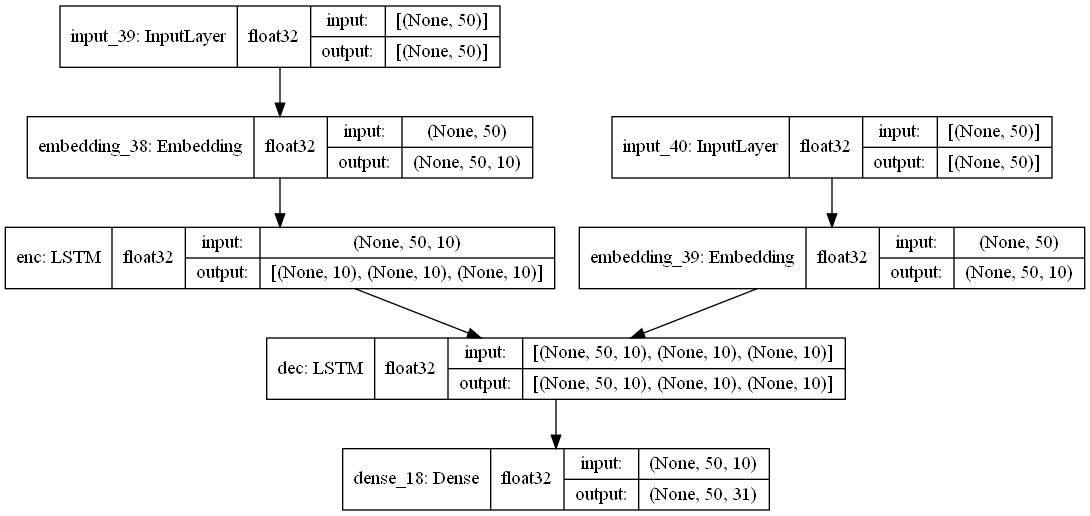

In [104]:
encoder_inputs, encoder_outputs, encoder_last_state = Encoder()
decoder_inputs, decoder_outputs = Decoder(encoder_last_state)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
print(type(Y_train))
print(model.summary())
plot_model(model, to_file="a.png",show_shapes=True, show_dtype=True)

In [100]:
Y_train.shape

(5208, 50)

In [113]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [114]:
X_test_decoder.shape

(1303, 50)

In [122]:
model.fit([X_train_encoder, X_train_decoder], Y_train, batch_size=16, epochs=30, validation_data=([X_test_encoder, X_test_decoder], Y_test))

Epoch 1/30
326/326 [==============================] - 13s 40ms/step - loss: 0.2184 - accuracy: 0.9328 - val_loss: 0.2194 - val_accuracy: 0.9327
Epoch 2/30
326/326 [==============================] - 15s 46ms/step - loss: 0.2158 - accuracy: 0.9339 - val_loss: 0.2168 - val_accuracy: 0.9339
Epoch 3/30
326/326 [==============================] - 15s 45ms/step - loss: 0.2137 - accuracy: 0.9346 - val_loss: 0.2153 - val_accuracy: 0.9340
Epoch 4/30
326/326 [==============================] - 19s 57ms/step - loss: 0.2121 - accuracy: 0.9350 - val_loss: 0.2140 - val_accuracy: 0.9346
Epoch 5/30
326/326 [==============================] - 15s 47ms/step - loss: 0.2108 - accuracy: 0.9352 - val_loss: 0.2124 - val_accuracy: 0.9347
Epoch 6/30
326/326 [==============================] - 14s 43ms/step - loss: 0.2097 - accuracy: 0.9356 - val_loss: 0.2116 - val_accuracy: 0.9348
Epoch 7/30
326/326 [==============================] - 16s 48ms/step - loss: 0.2087 - accuracy: 0.9358 - val_loss: 0.2106 - val_accuracy:

In [116]:
y_pred = model.predict([X_test_encoder, X_test_decoder])

4. If you input a very long sentence, do you have problem of translation this sentence? If so, what could be potentially the problem? Write down the answer. [2 Points]

A - I believe that aa vanilla RNN architecture will perform increasingly poorly in long sequences. This is because the longer the sequence, the farther away the distance is between the encoder input and decoder output will be. This will create long-term dependencies that are difficult to handle. This in turn will result in the "vanishing gradient" problem whereby gradients in backpropagation are separated by so many steps that they end up vanishing to 0 (or sometimes exploding).

5. What model or activation function can you use the improve long sentence translation? Implement such a model. [2 Points]

A - One simple solution to use is to keep things stable (no exploding or vanishing gradients) by using gradient clipping. Gradient clipping ensures the gradient has a norm of at most 7. While the gradients will be biased. at least they won't blow up. We can also reverse the input sequence so that there is only one time step between the first unit of the input and the first unit of the output. Usually in English, and similarly in this particular Pig-Latin application, dependencies are between units in the same or close positions within the input and output sequence. Another approach would be to modify the architecture entirely by replacing the RNN units by LSTM units that contain memory cells which have controllers saying when to store or forget information.

In [120]:

def Encoder(vocab_size=31,embedding_size=10,input_length=80):
    encoder_inputs = Input(shape=(input_length))
    embedder = Embedding(vocab_size, embedding_size, input_length=input_length)
    encoder_emb = embedder(encoder_inputs)
    encoder = LSTM(embedding_size, return_state=True, name = "enc")
    encoder_outputs, state_h, state_c = encoder(encoder_emb)
    encoder_last_state = [state_h, state_c]
    return encoder_inputs, encoder_outputs, encoder_last_state

def Decoder(encoder_last_state, vocab_size=31, embedding_size=10, input_length=80):
    decoder_inputs = Input(shape=(input_length))
    embedder = Embedding(vocab_size, embedding_size, input_length=input_length)  
    decoder_emb = embedder(decoder_inputs)  
    decoder_lstm = LSTM(embedding_size, return_sequences=True, return_state=True, name = "dec")
    decoder_outputs, _, _  = decoder_lstm(decoder_emb, initial_state=encoder_last_state)
    decoder_dense = Dense(vocab_size, activation="softmax")
    decoder_outputs = decoder_dense(decoder_outputs)
    return decoder_inputs, decoder_outputs

encoder_inputs, encoder_outputs, encoder_last_state = Encoder()
decoder_inputs, decoder_outputs = Decoder(encoder_last_state)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

model.fit([X_train_encoder, X_train_decoder], Y_train, batch_size=16, epochs=30, validation_data=([X_test_encoder, X_test_decoder], Y_test))

y_pred = model.predict([X_test_encoder, X_test_decoder])

Epoch 1/30
326/326 [==============================] - 14s 36ms/step - loss: 1.1654 - accuracy: 0.8714 - val_loss: 0.4026 - val_accuracy: 0.9081
Epoch 2/30
326/326 [==============================] - 11s 34ms/step - loss: 0.3471 - accuracy: 0.9150 - val_loss: 0.3245 - val_accuracy: 0.9166
Epoch 3/30
326/326 [==============================] - 11s 34ms/step - loss: 0.3082 - accuracy: 0.9184 - val_loss: 0.3018 - val_accuracy: 0.9172
Epoch 4/30
326/326 [==============================] - 12s 37ms/step - loss: 0.2917 - accuracy: 0.9184 - val_loss: 0.2892 - val_accuracy: 0.9172
Epoch 5/30
326/326 [==============================] - 12s 37ms/step - loss: 0.2813 - accuracy: 0.9184 - val_loss: 0.2798 - val_accuracy: 0.9174
Epoch 6/30
326/326 [==============================] - 12s 37ms/step - loss: 0.2725 - accuracy: 0.9205 - val_loss: 0.2713 - val_accuracy: 0.9227
Epoch 7/30
326/326 [==============================] - 12s 37ms/step - loss: 0.2650 - accuracy: 0.9241 - val_loss: 0.2646 - val_accuracy: